In [564]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Momento de Retroalimentación: Reto Limpieza del Conjunto de Datos

## Predicciones de venta para las tiendas Favorita

Documento de análisis: https://docs.google.com/document/d/1WZNxJ-wSE6K8wZKmX6lFai6Z2BT1WmAgjC3g8u6PCs0/edit

Presentación de avance: https://docs.google.com/presentation/d/1VzJBf_ssgdRzuZ6XmWEBgiDqbYzE2eqXWB2ucQNZnp8/edit#slide=id.g608d0fa1da_0_8133

### Equipo:

**- Fermín Méndez García A01703366**

**- Emiliano Vásquez Olea A01707035**

**- Diego Emilio Barrera  A01366802**

**- Karen Cebreros López A01704254**

### Contenido

1.  Extracción de los datos
2.  Limpieza de los datos
3.  Análisis exploratorio de los datos
4.  Modelos de predicción


# 1. Extracción de los datos

In [565]:
DATA_PATH = '../input/store-sales-time-series-forecasting'

# Carga de datos

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_stores = pd.read_csv('data/stores.csv')
df_transactions = pd.read_csv('data/transactions.csv')
df_oil = pd.read_csv('data/oil.csv')
df_holidays = pd.read_csv('data/holidays_events.csv')

In [566]:
df_stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


### 2 Limpieza de los datos

### 2.1 Identificar valores faltantes e imputación de los datos

In [567]:
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [568]:
# Llenar datos faltantes del precio del petróleo con el valor del dia posterior
df_oil.fillna(method='bfill', inplace = True)

In [569]:
df_oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

### 2.2 Eliminando valores que no aportan información

En este caso eliminamos registros sin ventas de ciertas tiendas, indicando posiblemente una falta de información o que las sucursales no habían sido abiertas.

In [570]:
df_train = df_train[~((df_train.store_nbr == 52) & (df_train.date < '2017-04-20'))]
df_train = df_train[~((df_train.store_nbr == 22) & (df_train.date < '2015-10-09'))]
df_train = df_train[~((df_train.store_nbr == 42) & (df_train.date < '2015-08-21'))]
df_train = df_train[~((df_train.store_nbr == 21) & (df_train.date < '2015-07-24'))]
df_train = df_train[~((df_train.store_nbr == 29) & (df_train.date < '2015-03-20'))]
df_train = df_train[~((df_train.store_nbr == 20) & (df_train.date < '2015-02-13'))]
df_train = df_train[~((df_train.store_nbr == 53) & (df_train.date < '2014-05-29'))]
df_train = df_train[~((df_train.store_nbr == 36) & (df_train.date < '2013-05-09'))]

### 2.3 Identificar valores atípicos

En la sección 2.3 completar:
-Máximos y mínimos de las ventas
-Gráfica de ventas por cada año
En esta parte hay que identificar el periodo del terremoto e imputar los datos para no afectar el modelo.

# 3 Análisis exploratorio de los datos

### 3.1 Análisis de datos principales que usaremos para el modelo

In [571]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [572]:
df_train.describe()

,id,store_nbr,sales,onpromotion
count,2.780316e+06,2.780316e+06,2.780316e+06,2.780316e+06
mean,1.547738e+06,2.690357e+01,3.861593e+02,2.809257e+00
std,8.648191e+05,1.558373e+01,1.140079e+03,1.267145e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.034178e+05,1.300000e+01,0.000000e+00,0.000000e+00
50%,1.580370e+06,2.700000e+01,1.600000e+01,0.000000e+00
75%,2.296634e+06,4.000000e+01,2.270000e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


Eliminamos la columna de id del dataset de entrenamiento, ya que es un identificador único

In [573]:
df_train.drop(['id'], axis = 1, inplace = True)

Aplicamos One Hot Encoding sobre los datos de entrenamiento para representar los valores categóricos de la columna "family" de forma numérica.

In [574]:
encoded_family_df = pd.get_dummies(df_train['family'], prefix='family')
df_train_encoded = pd.concat([df_train, encoded_family_df], axis = 1).drop(['family'], axis = 1)

In [575]:
df_train_encoded

,date,store_nbr,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,2013-01-01,1,0.000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-01,1,0.000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-01,1,0.000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-01,1,0.000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-01,1,0.000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,438.133,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3000884,2017-08-15,9,154.553,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3000885,2017-08-15,9,2419.729,148,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3000886,2017-08-15,9,121.000,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


La aplicación del one hot encoding fué un método usado inicialmente para intentar representar todos nuestros atributos de forma numérica para que fueran utilizables dentro de una regresión lineal.
Mientras que la regresión lineal si es utilizada como propuesta de solución, la aplicación de este one hot encoding no fué necesaria debido al uso de "unstack" para reorganizar los datos.

Graficamos la correlación entre las variables originales

C:\Users\emili\AppData\Local\Temp\ipykernel_7392\2372759694.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



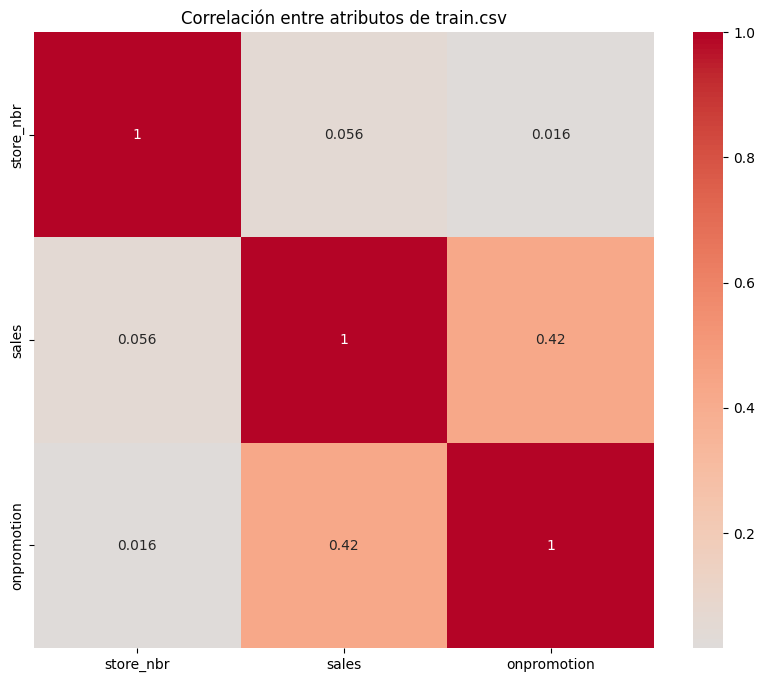

In [576]:
correlation_matrix = df_train.corr()

# Set up the heatmap figure
plt.figure(figsize = (10, 8))

# Create heatmap using seaborn
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", center = 0)

# Show the plot
plt.title("Correlación entre atributos de train.csv")
plt.show()

En la gráfica anterior podemos ver como se correlacionan las variables entre las variables del dataset. 
Esta gráfica nos sirve meramente para visualizar como es que pueden variar los valores de una variable (valga la redundancia), dependiendo a los valores de otra. Por ejemplo, podemos ver que hay una correlación casi de .5 entre sales y onpromotion; lo cual hace sentido por la naturaleza y el objetivo de la variable onpromotion.

Sacamos el promedio de ventas por todas las tiendas en un día.

In [577]:
average_sales = df_train.groupby('date')['sales'].mean()
average_sales_df = average_sales.reset_index()

Gráfico de datos y marcar tendencia a lo largo de los años

In [578]:
px.scatter(x = pd.to_datetime(average_sales_df["date"]), y = average_sales_df["sales"], trendline="ols", trendline_color_override = 'red')

Es posible que algunos de los valores extremos se deban a situaciones especiales, como el terremoto de gran magnitud del 2016 en Ecuador.

In [579]:
average_sales_by_family = df_train.groupby('family')['sales'].mean()

### 3.2 Análisis del precio del petróleo

El petróleo es un factor que refleja la economía de Ecuador, al ser un país petrolero. Este es uno de los indicadores externos que puede afectar las ventas de las tiendas Favorita, por lo que es importante tomarlo en cuenta.

In [580]:
df_oil.describe()

,dcoilwtico
count,1218.000000
mean,67.673325
std,25.637345
min,26.190000
25%,46.422500
50%,53.185000
75%,95.595000
max,110.620000


En estos datos vemos un valor mínimo de 26 y un máximo de 110, mostrando una gran variabilidad entre años. Este máximo es más de cuatro veces el valor mínimo.

<AxesSubplot: xlabel='date', ylabel='dcoilwtico'>

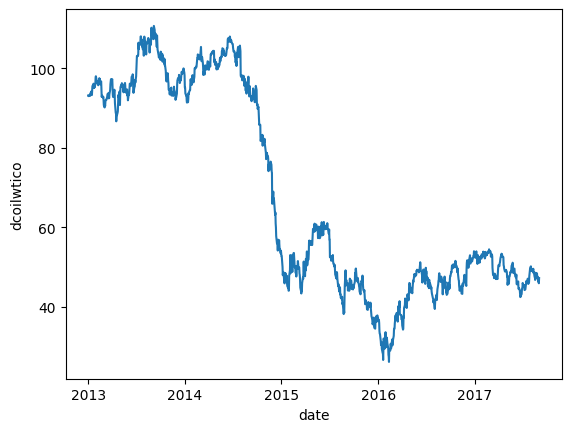

In [581]:
sns.lineplot(df_oil, x = pd.to_datetime(df_oil["date"]), y = df_oil["dcoilwtico"])

En la gráfica anterior podemos observar como es que el valor del petróleo fue variando desde el 2013 hasta el 2018 aproximadamente.

Analizando un poco lo que aparece en la gráfica, podemos ver que antes del 2015, el valor de éste era por lo menos el doble de lo que era en el resto de los años.

De igual forma, podemos ver que hay un punto en el tiempo (2016) en donde éste llegó a su valor mínimo, que fue una cuarta parte del valor máxiámo que había alcanzado. Después de un breve periodo de tiempo, vuelve a subir casi hasta su valor promedio.

### 3.4 Análisis de transacciones

In [582]:
df_transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


Promedio de transacciones en un día

In [583]:
average_transactions = df_transactions.groupby('date')['transactions'].mean()
average_transactions_df = average_transactions.reset_index()

In [584]:
px.scatter(x = pd.to_datetime(average_transactions_df["date"]), y = average_transactions_df["transactions"], trendline="ols", trendline_color_override = 'red')

En el gráfico anterior podemos observar todas las transacciones a lo largo de los años. Se puede ver que al final de cada año, hay una tendencia a que se eleve la cantidad de transacciones a casi el doble de las que hay normalmente. Intuímos que esto pasa debido a la temporada y las eventualidades a finales de cada año.

### 3.5  Análisis de relación entre Oil y Transactions

In [585]:
average_price = df_oil.groupby('date')['dcoilwtico'].mean()
average_price.head()

date
2013-01-01    93.14
2013-01-02    93.14
2013-01-03    92.97
2013-01-04    93.12
2013-01-07    93.20
Name: dcoilwtico, dtype: float64

<AxesSubplot: title={'center': 'Average of Oil Price'}, xlabel='date'>

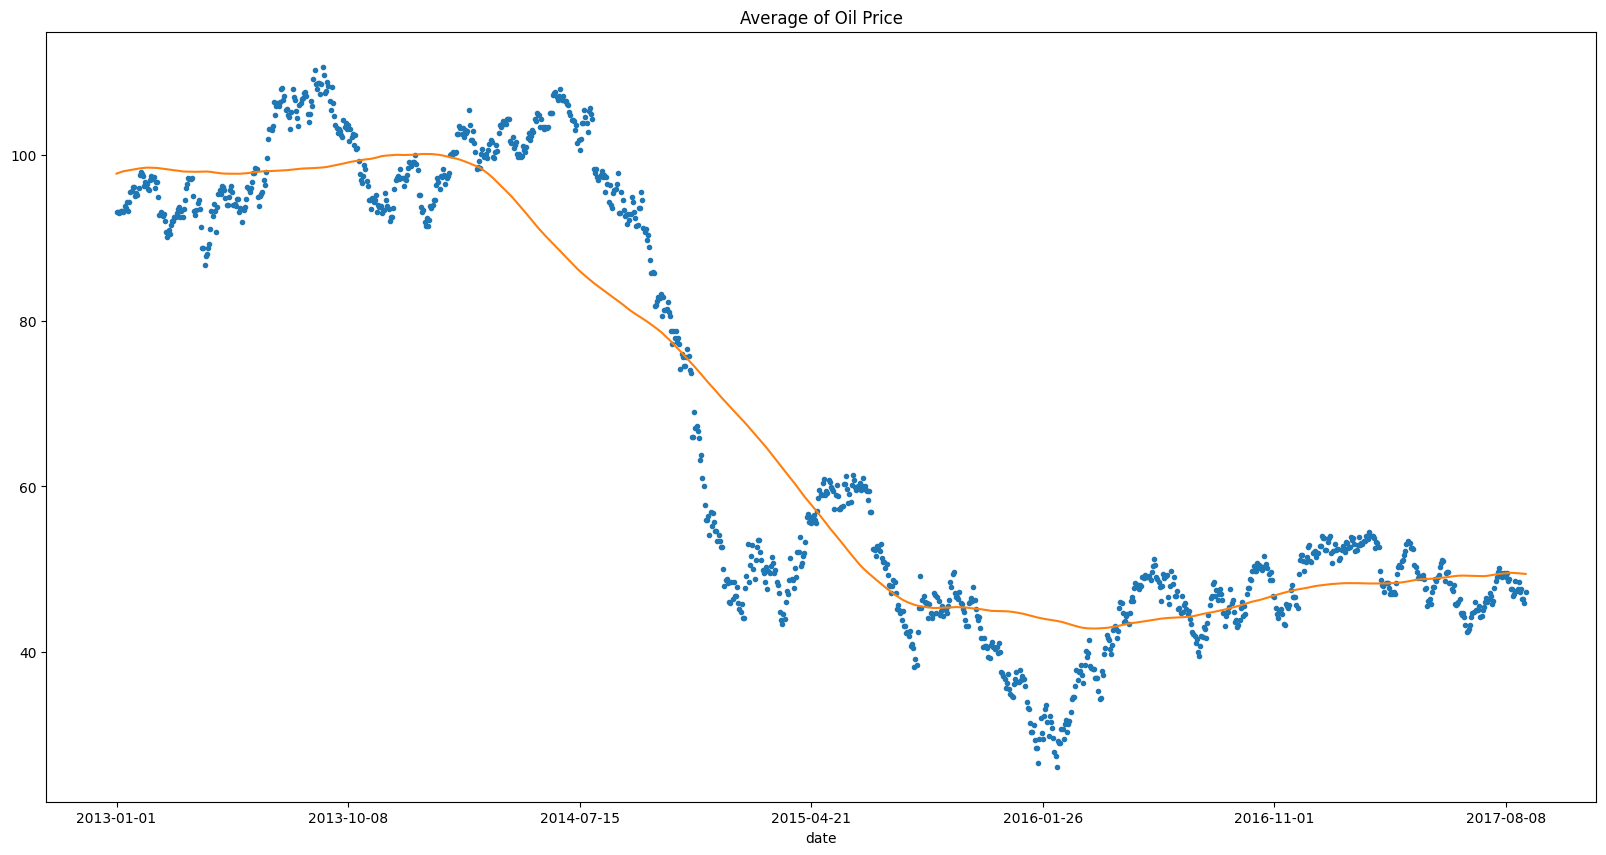

In [586]:
moving_average3 = average_price.rolling(window=365, center=True, min_periods=183).mean()
average_price.plot(style='.',figsize=(20,10), title='Average of Oil Price')
moving_average3.plot()

<AxesSubplot: title={'center': 'Average of Transaction'}, xlabel='date'>

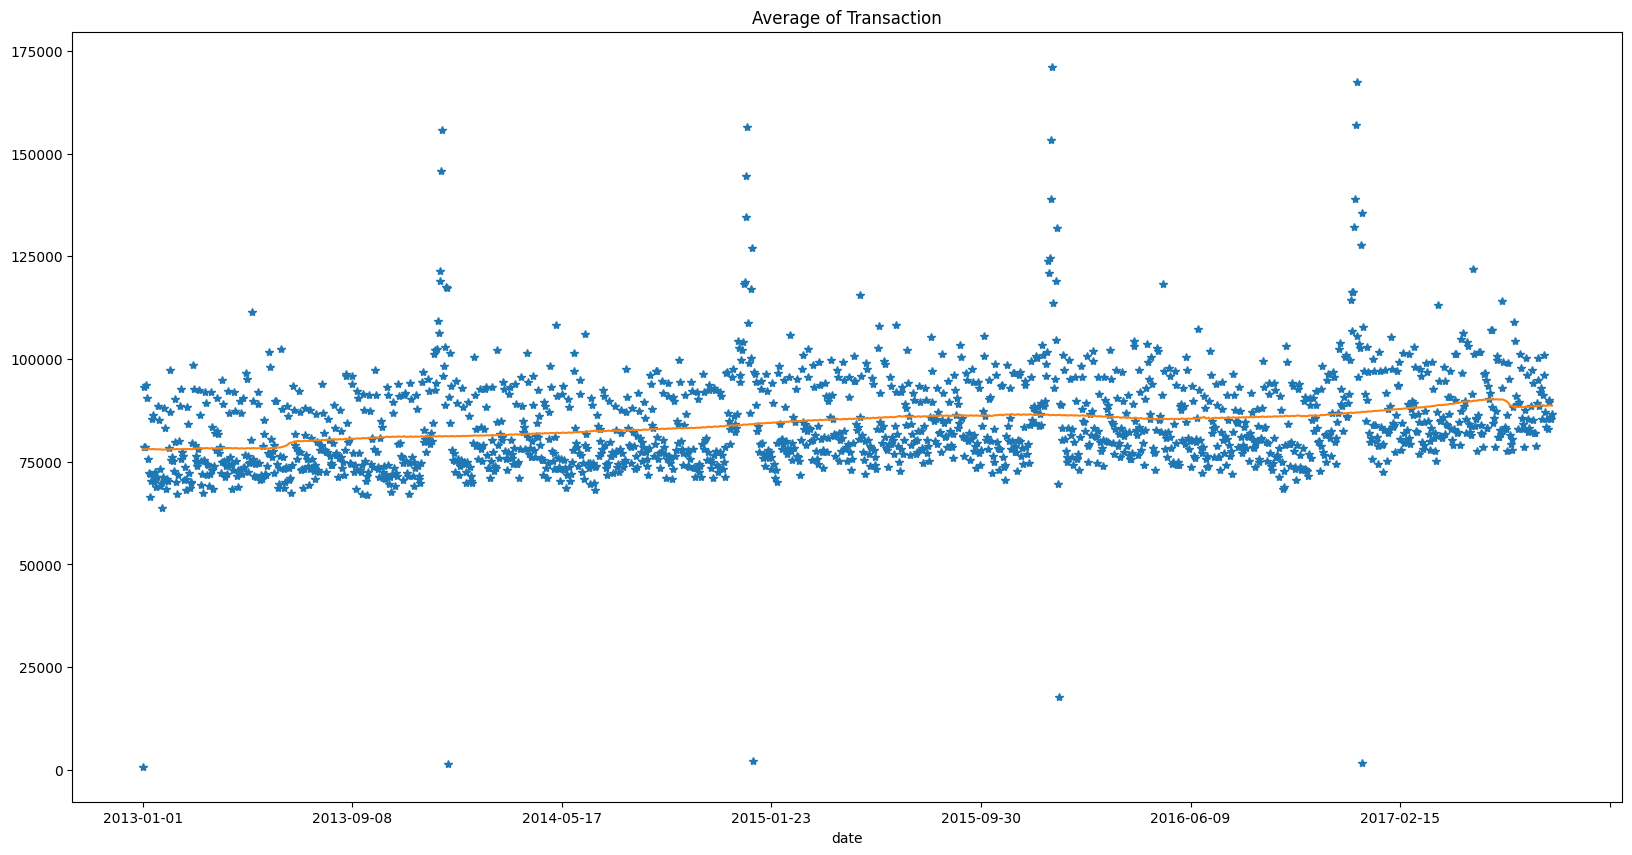

In [587]:
sum_transaction = df_transactions.groupby('date').sum()['transactions']
sum_transaction = sum_transaction.copy()
moving_sum_transaction = sum_transaction.rolling(window=365, center=True, min_periods=183).mean()
sum_transaction.plot(style='*', figsize=(20, 10), title='Average of Transaction')
moving_sum_transaction.plot()

### ¿Qué observamos?
Comprobamos si existe alguna relación entre el precio del petróleo y la transacción.
Obtenemos el gráfico del precio del petróleo frente al tiempo del precio del petróleo.
y luego tenemos el gráfico de Transacción contra el tiempo.


Notamos que para el gráfico del precio del petróleo, está bajando en 4 años,
y para el gráfico de transacciones, es casi estable en 4 años.
Se confirma que es posible que no tengan una relación lineal.

### 3.6 Análisis de relación entre Sales y Transactions

C:\Users\emili\AppData\Local\Temp\ipykernel_7392\1684016106.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<AxesSubplot: title={'center': 'Average of Sales'}, xlabel='date'>

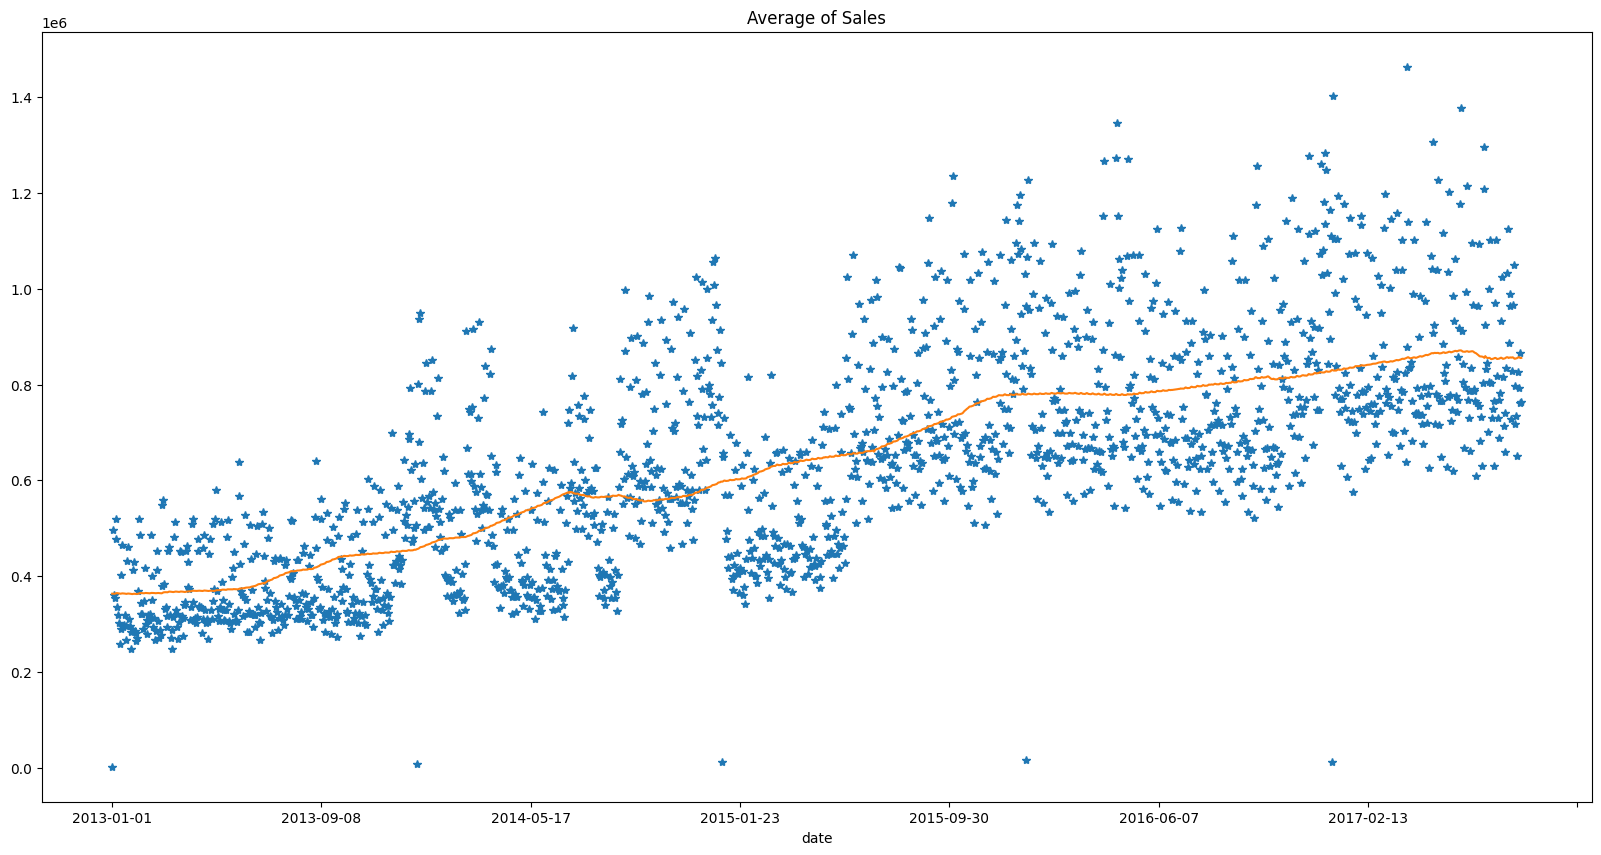

In [588]:
sum_sales = df_train.groupby('date').sum()['sales']
sum_sales = sum_sales.copy()
moving_sum_sales = sum_sales.rolling(window=365, center=True, min_periods=183).mean()
sum_sales.plot(style='*', figsize=(20, 10), title='Average of Sales')
moving_sum_sales.plot()

Podemos observar que las ventas si están creciendo conforme pasa el tiempo, pero no de una forma lineal, sino que hay ciertos periodos en los que crece más que en otros, a diferencia de las transacciones, que se mantienen casi constantes.

<AxesSubplot: title={'center': 'Transaction Vs Sales'}, xlabel='transactions', ylabel='sales'>

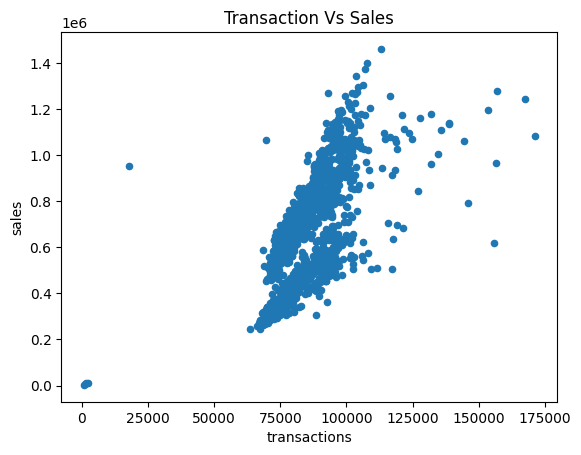

In [589]:
date_transaction_sales = pd.merge(sum_transaction, sum_sales, on='date')
date_transaction_sales.plot.scatter(x='transactions', y='sales', title='Transaction Vs Sales')

### ¿Qué observamos?
Podemos observar que hay una clara relación entre las ventas y las transacciones, ya que conforme aumentan las transacciones, también aumentan las ventas.

### 3.7 Análisis por estaciones

In [590]:
#from learntools.time_series.utils import plot_periodogram, seasonal_plot

Identificar los periodos de tiempo donde existen patrones fuertes en el comportamiento.

In [591]:
#plot_periodogram(average_sales);

In [592]:
"""
store_sales = pd.read_csv(
    os.path.join(DATA_PATH, 'train.csv'),
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
"""

"\nstore_sales = pd.read_csv(\n    os.path.join(DATA_PATH, 'train.csv'),\n    usecols=['store_nbr', 'family', 'date', 'sales'],\n    dtype={\n        'store_nbr': 'category',\n        'family': 'category',\n        'sales': 'float32',\n    },\n    parse_dates=['date'],\n    infer_datetime_format=True,\n)\nstore_sales['date'] = store_sales.date.dt.to_period('D')\nstore_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()\naverage_sales = (\n    store_sales\n    .groupby('date').mean()\n    .squeeze()\n    .loc['2017']\n)\n"

Promedio de ventas por dia en cada tienda en el año 2017

In [593]:
'''
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');
'''

'\nX = average_sales.to_frame()\nX["week"] = X.index.week\nX["day"] = X.index.dayofweek\nseasonal_plot(X, y=\'sales\', period=\'week\', freq=\'day\');\n'

## Transformación de datos para entrenamiento

Para entrenar nuestro modelo de regresión lineal queremos extraer datos sobre la estacionalidad en nuestro dataset. Como vimos en graficos anteriores, se sigue un patrón a lo largo del año desde varianza en las ventas en diferentes días de la semana, hasta aquellos cambios producidos por dias festivos.

Para poder respresentar este comportamiento en nuestro modelo es necesario que transformemos nuestros datos de entrenamiento, que nos indican fechas, el producto, número de la tienda y ventas, en componentes de Fourier.

Primero reasignamos nuestro índice y el tipo de dato de la fecha, ya que estos deben ser compatibles con la función de DeterministicProcess que se usará más adelante.

In [594]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['date'] = df_train.date.dt.to_period('D')

df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

Aplicando la función unstack reorganizamos nuestros datos de entrenamiento. De esta forma cada fila de nuestro dataset solo representará una fecha, pero se agregan columnas para representar toda la información sobre las ventas por tipo de producto y número de tienda.

In [595]:
df_train_unstacked = df_train.unstack(['store_nbr','family'])

In [596]:
df_train_unstacked

sales                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0    470.65200   
2013-01-03        3.0       0.0    0.0     919.0   0.0    310.65500   
2013-01-04        3.0       0.0    3.0     953.0   0.0    198.36600   
2013-01-05        5.0       0.0    3.0    1160.0   0.0    301.05700   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

                                                 ... onpromotion        \
store_nbr                                        ...          54         
family     CELEBRATION CLEANING  DAIRY     DELI  ...   MAGAZINES MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...         0.0   0.0   
2013-01-02         0.0   1060.0  579.0  164.069  ...         0.0   0.0   
2013-01-03         0.0    836.0  453.0  151.582  ...         0.0   0.0   
2013-01-04         0.0    827.0  460.0  131.411  ...         0.0   0.0   
2013-01-05         0.0    811.0  464.0  118.613  ...         0.0   0.0   
...                ...      ...    ...      ...  ...         ...   ...   
2017-08-11         4.0    341.0  343.0   64.302  ...         0.0   0.0   
2017-08-12         3.0    351.0  526.0   99.488  ...         0.0   0.0   
2017-08-13         1.0    169.0  266.0   47.770  ...         0.0   0.0   
2017-08-14         4.0    571.0  699.0  154.578  ...         0.0   0.0   
2017-08-15        21.0    703.0  602.0  116.402  ...         0.0   0.0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0     0.0   
2013-01-02           0.0          0.0                     0.0     0.0   
2013-01-03           0.0          0.0                     0.0     0.0   
2013-01-04           0.0          0.0                     0.0     0.0   
2013-01-05           0.0          0.0                     0.0     0.0   
...                  ...          ...                     ...     ...   
2017-08-11           6.0          0.0                     0.0    10.0   
2017-08-12           5.0          0.0                     0.0     0.0   
2017-08-13           6.0          0.0                     0.0     0.0   
2017-08-14           6.0          0.0                     0.0     0.0   
2017-08-15           5.0          0.0                     0.0     0.0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02            0.0     0.0                        0.0     0.0  
2013-01-03            0.0     0.0                        0.0     0.0  
2013-01-04            0.0     0.0                        0.0     0.0  
2013-01-05            0.0     0.0                        0.0     0.0  
...                   ...     ...                        ...     ...  
2017-08-11            0.0     3.0

La función DeterministicProcess se encarga de generar diferentes términos determinísticos sobre nuestros datos de entrada, que son los nuevos "features" que describen el comportamiento de los datos a lo largo del tiempo. Estos son los datos que podemos utilizar para entrenar nuestro modelo de aprendizaje automático y posteriormente realizar nuestras predicciones.

In [597]:
fourier_terms = CalendarFourier(freq='Y', order=4)

dp = DeterministicProcess(
    index = df_train_unstacked.index,
    constant = True,
    order = 0,
    seasonal = True,
    additional_terms = [fourier_terms],
    drop = True,
)

df_x_train = dp.in_sample()
df_x_train

,const,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
date,,,,,,,,,,,,,,,
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630
2013-01-03,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532
2013-01-04,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740
2013-01-05,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.628763,-0.777597,0.977848,0.209315,-0.891981,0.452072,0.409356,-0.912375
2017-08-12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.642055,-0.766659,0.984474,0.175531,-0.867456,0.497513,0.345612,-0.938377
2017-08-13,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.655156,-0.755493,0.989932,0.141540,-0.840618,0.541628,0.280231,-0.959933


### Días festivos

Ya que tenemos nuestros "features" para cada día que compone el dataset, debemos agregar otros atributos importantes para nuestro análisis, que puede incluir la información que vemos en los demás datasets del reto.

Por ejemplo, los días festivos. Del archivo holidays.csv podemos obtener información que describa cierto comportamiento en días específicos del año, por ejemplo, la falta de ventas a inicios de año, o una mayor demanda en preparación a fiestas nacionales. Estos datos nos permiten agregar características a nuestro modelo para incluir estos comportamientos que no siempre son descritos por la información más general de estacionalidad.

In [598]:
df_holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Aplicamos One Hot Encoding sobre los datos de df_holidays para representar sus valores categóricos de forma numérica.

In [599]:
df_holidays_encoded = pd.get_dummies(df_holidays['description'], prefix='holiday')

# Al ejecutar la función get_dummies perdemos la columna de fechas, la cual requerimos para realizar el join mas adelante con nuestros features iniciales
df_holidays_encoded = pd.concat([df_holidays_encoded, df_holidays['date']], axis = 1) # Volvemos a agregar la columna de fechas
df_holidays_encoded['date'] = pd.to_datetime(df_holidays_encoded['date']).dt.to_period('D') # Cambiamos pormato de fecha a Period para que sea igual al índice de los features

df_holidays_encoded = df_holidays_encoded.set_index('date')

Después de haber aplicado este proceso, podemos ver que, como algunas celebraciones ocurren en un mismo día, se duplican los registros para algunas fechas. Por ejemplo, el 14 de Abril se celebra un Viernes Santo, así como la Cantonizacion de Libertad.

In [600]:
df_holidays_encoded.loc[['2017-04-14']]

,holiday_Batalla de Pichincha,holiday_Black Friday,holiday_Cantonizacion de Cayambe,holiday_Cantonizacion de El Carmen,holiday_Cantonizacion de Guaranda,holiday_Cantonizacion de Latacunga,holiday_Cantonizacion de Libertad,holiday_Cantonizacion de Quevedo,holiday_Cantonizacion de Riobamba,holiday_Cantonizacion de Salinas,...,holiday_Terremoto Manabi+7,holiday_Terremoto Manabi+8,holiday_Terremoto Manabi+9,holiday_Traslado Batalla de Pichincha,holiday_Traslado Fundacion de Guayaquil,holiday_Traslado Fundacion de Quito,holiday_Traslado Independencia de Guayaquil,holiday_Traslado Primer Grito de Independencia,holiday_Traslado Primer dia del ano,holiday_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-04-14,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-04-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Es por ello que debemos aplicar otra transformación sobre estos datos para agrupar una fecha en una misma fila.

In [601]:
df_holidays_encoded = df_holidays_encoded.groupby(df_holidays_encoded.index).sum()

De esta forma hemos transformado nuestro dataframe con los dias festivos para indicar, para cada una de las fechas registradas, si hay o no un evento festivo en específico.

Esto nos permite utilizar estos atributos dentro de nuestro modelo de regresión lineal.

In [602]:
df_holidays_encoded

,holiday_Batalla de Pichincha,holiday_Black Friday,holiday_Cantonizacion de Cayambe,holiday_Cantonizacion de El Carmen,holiday_Cantonizacion de Guaranda,holiday_Cantonizacion de Latacunga,holiday_Cantonizacion de Libertad,holiday_Cantonizacion de Quevedo,holiday_Cantonizacion de Riobamba,holiday_Cantonizacion de Salinas,...,holiday_Terremoto Manabi+7,holiday_Terremoto Manabi+8,holiday_Terremoto Manabi+9,holiday_Traslado Batalla de Pichincha,holiday_Traslado Fundacion de Guayaquil,holiday_Traslado Fundacion de Quito,holiday_Traslado Independencia de Guayaquil,holiday_Traslado Primer Grito de Independencia,holiday_Traslado Primer dia del ano,holiday_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2012-03-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-14,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-21,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2017-12-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ya que tenemos nuestros datos de días festivos codificados, vamos a unirlos a nuestros features originales (Los obtenidos a partir del Deterministic Process)

In [603]:
df_x_train = df_x_train.join(df_holidays_encoded).fillna(0) # Llenamos los valores faltantes con 0, indicando que no sucede el día festivo

In [604]:
df_x_train

,const,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)",...,holiday_Terremoto Manabi+7,holiday_Terremoto Manabi+8,holiday_Terremoto Manabi+9,holiday_Traslado Batalla de Pichincha,holiday_Traslado Fundacion de Guayaquil,holiday_Traslado Fundacion de Quito,holiday_Traslado Independencia de Guayaquil,holiday_Traslado Primer Grito de Independencia,holiday_Traslado Primer dia del ano,holiday_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.628763,-0.777597,0.977848,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-08-12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.642055,-0.766659,0.984474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.655156,-0.755493,0.989932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Propuesta de solución

In [605]:
y = df_train_unstacked.fillna(0)

model = LinearRegression(fit_intercept = True)
model.fit(df_x_train, y)

LinearRegression()

In [606]:
y_pred = pd.DataFrame(model.predict(df_x_train), index=df_x_train.index, columns=y.columns)

In [607]:
y

sales                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0    470.65200   
2013-01-03        3.0       0.0    0.0     919.0   0.0    310.65500   
2013-01-04        3.0       0.0    3.0     953.0   0.0    198.36600   
2013-01-05        5.0       0.0    3.0    1160.0   0.0    301.05700   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

                                                 ... onpromotion        \
store_nbr                                        ...          54         
family     CELEBRATION CLEANING  DAIRY     DELI  ...   MAGAZINES MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...         0.0   0.0   
2013-01-02         0.0   1060.0  579.0  164.069  ...         0.0   0.0   
2013-01-03         0.0    836.0  453.0  151.582  ...         0.0   0.0   
2013-01-04         0.0    827.0  460.0  131.411  ...         0.0   0.0   
2013-01-05         0.0    811.0  464.0  118.613  ...         0.0   0.0   
...                ...      ...    ...      ...  ...         ...   ...   
2017-08-11         4.0    341.0  343.0   64.302  ...         0.0   0.0   
2017-08-12         3.0    351.0  526.0   99.488  ...         0.0   0.0   
2017-08-13         1.0    169.0  266.0   47.770  ...         0.0   0.0   
2017-08-14         4.0    571.0  699.0  154.578  ...         0.0   0.0   
2017-08-15        21.0    703.0  602.0  116.402  ...         0.0   0.0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0     0.0   
2013-01-02           0.0          0.0                     0.0     0.0   
2013-01-03           0.0          0.0                     0.0     0.0   
2013-01-04           0.0          0.0                     0.0     0.0   
2013-01-05           0.0          0.0                     0.0     0.0   
...                  ...          ...                     ...     ...   
2017-08-11           6.0          0.0                     0.0    10.0   
2017-08-12           5.0          0.0                     0.0     0.0   
2017-08-13           6.0          0.0                     0.0     0.0   
2017-08-14           6.0          0.0                     0.0     0.0   
2017-08-15           5.0          0.0                     0.0     0.0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02            0.0     0.0                        0.0     0.0  
2013-01-03            0.0     0.0                        0.0     0.0  
2013-01-04            0.0     0.0                        0.0     0.0  
2013-01-05            0.0     0.0                        0.0     0.0  
...                   ...     ...                        ...     ...  
2017-08-11            0.0     3.0

In [608]:
y_pred

sales                                                       \
store_nbr          1                                                         
family     AUTOMOTIVE BABY CARE    BEAUTY BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                         
2013-01-01   0.006104       0.0  0.061035    34.125 -0.005493      5.65625   
2013-01-02   3.376221       0.0  2.275391  1819.125  0.205353    357.56250   
2013-01-03   2.825989       0.0  2.244141  1701.125  0.149078    316.28125   
2013-01-04   2.996948       0.0  2.352051  1742.125  0.261078    313.40625   
2013-01-05   5.006317       0.0  2.990967  1150.875 -0.001251    300.87500   
...               ...       ...       ...       ...       ...          ...   
2017-08-11   1.112671       0.0  2.028809   990.750  0.005554    172.21875   
2017-08-12   3.524139       0.0  2.656006  1615.375 -0.025940    357.84375   
2017-08-13   3.481903       0.0  2.391357  1447.125  0.001007    331.53125   
2017-08-14   2.912598       0.0  2.366211  1340.000 -0.055023    290.65625   
2017-08-15   3.299744       0.0  2.296631  1864.125  0.067566    388.90625   

                                                        ... onpromotion  \
store_nbr                                               ...          54   
family     CELEBRATION  CLEANING     DAIRY        DELI  ...   MAGAZINES   
date                                                    ...               
2013-01-01    0.382812    9.4375   13.8125    1.679688  ...   -0.003647   
2013-01-02    8.451172  751.0625  671.0000  136.109375  ...    0.000275   
2013-01-03    6.039062  651.3125  622.1250  124.578125  ...   -0.002014   
2013-01-04    6.011719  654.3125  627.6250  124.703125  ...   -0.014343   
2013-01-05   -0.003906  811.1875  462.8125  117.867188  ...    0.000015   
...                ...       ...       ...         ...  ...         ...   
2017-08-11    5.527344  338.0000  357.9375   56.585938  ...   -0.002136   
2017-08-12    8.787109  694.0625  635.6875  127.320312  ...   -0.006088   
2017-08-13    6.544922  642.3750  568.2500  120.507812  ...    0.011597   
2017-08-14    4.099609  543.3125  521.5625  109.195312  ...    0.008789   
2017-08-15    9.738281  691.3125  633.5000  130.890625  ...   -0.007507   

                                                                         \
store_nbr                                                                 
family         MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                      
2013-01-01  0.228516     -0.057373    -0.002731               -0.005264   
2013-01-02  1.137695      1.875977     0.004196               -0.019562   
2013-01-03 -0.038086      1.806396     0.004227               -0.021194   
2013-01-04 -0.020508      1.553955    -0.008865               -0.031265   
2013-01-05  0.001953     -0.005371    -0.000015               -0.000244   
...              ...           ...          ...                     ...   
2017-08-11 -0.070312      4.297363    -0.000122               -0.007233   
2017-08-12  2.594727      1.566650    -0.004578               -0.011276   
2017-08-13  1.469727      1.837158     0.009399                0.016342   
2017-08-14  0.296875      1.789795     0.009476                0.015259   
2017-08-15  0.004883      1.605225    -0.007950               -0.005661   

                                                                           \
store_nbr                                                                   
family       POULTRY PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                        
2013-01-01  0.097168      -0.001740  -0.058105                  -0.007935   
2013-01-02  1.618164       0.137234   0.337402                   0.038910   
2013-01-03  0.006348       0.143799   0.111328                   0.029724   
2013-01-04  0.031738       0.126549  10.071289        